# EPI Coding Challenge -- World Data Analysis (Task 1-3)

**Author:** Tank  
**Date:** 10 February 2025

## Overview

This notebook works through the coding challenge using the `worldData.csv` dataset -- an extract from the R package `spData` containing World Bank country information.

**Structure:**
- **Task 1:** Load the data into memory
- **Task 2:** Clean and transform the raw data, then export as CSV
- **Task 3:** Answer four analytical questions about the cleaned data

> An interactive filtering interface (Task 4) and visualisations are provided separately in the Streamlit app (`app.py`). See the README for instructions on running both.

---

## Task 1: Load the Data

The challenge provides a CSV file (`worldData.csv`). Can use `pd.read_csv()` directly.

> **Note:** `pandas` automatically recognises common missing-value representations like `#N/A` during import and converts them to `NaN`. This is standard behaviour and saves us a manual conversion step.

In [25]:
import pandas as pd
import numpy as np
import plotly.express as px

# Load the raw data
raw_df = pd.read_csv("worldData.csv")
print(f"Loaded {raw_df.shape[0]} rows and {raw_df.shape[1]} columns")
raw_df.head(10)

Loaded 189 rows and 12 columns


,Unnamed: 0,iso_a2,iso_a2.1,name_long,continent,region_un,subregion,type,area_km2,pop,lifeExp,gdpPercap
0,1,FJ,FJ,Fiji,Oceania,Oceania,Melanesia,Sovereign country,1.928997e+04,885806.0,69.960000,8222.253784
1,1,FJ,FJ,Fiji,Oceania,Oceania,Melanesia,Sovereign country,1.928997e+04,885806.0,69.960000,8222.253784
2,2,TZ,TZ,Tanzania,Africa,Africa,Eastern Africa,Sovereign country,9.327458e+05,52234869.0,64.163000,2402.099404
3,3,EH,EH,Western Sahara,Africa,Africa,Northern Africa,Indeterminate,9.627060e+04,NaN,NaN,NaN
4,4,CA,CA,Canada,North America,Americas,Northern America,Sovereign country,1.003604e+07,35535348.0,81.953049,43079.142520
5,5,US,US,United States,North America,Americas,Northern America,Country,9.510744e+06,318622525.0,78.841463,51921.984640
6,6,KZ,KZ,Kazakhstan,Asia,Asia,Central Asia,Sovereign country,2.729811e+06,17288285.0,71.620000,23587.337520
7,7,UZ,UZ,Uzbekistan,Asia,Asia,Central Asia,Sovereign country,4.614103e+05,30757700.0,71.039000,-5370.865802
8,8,PG,PG,Papua New Guinea,Oceania,Oceania,Melanesia,Sovereign country,4.645201e+05,7755785.0,65.230000,3709.081644
9,9,ID,ID,Indonesia,Asia,Asia,South-Eastern Asia,Sovereign country,1.819251e+06,255131116.0,68.856000,10003.089030


### Initial Exploration

Before cleaning, let's understand the structure: column names, data types, and a statistical summary. This helps us spot issues early.

In [26]:
# Check columns and data types
print("Columns:")
print(raw_df.columns.tolist())
print(f"\nData types:\n{raw_df.dtypes}")
print(f"\nShape: {raw_df.shape}")

Columns:
['Unnamed: 0', 'iso_a2', 'iso_a2.1', 'name_long', 'continent', 'region_un', 'subregion', 'type', 'area_km2', 'pop', 'lifeExp', 'gdpPercap']

Data types:
Unnamed: 0      int64
iso_a2         object
iso_a2.1       object
name_long      object
continent      object
region_un      object
subregion      object
type           object
area_km2      float64
pop           float64
lifeExp       float64
gdpPercap     float64
dtype: object

Shape: (189, 12)


In [27]:
# Statistical summary of numeric columns
raw_df.describe()

,Unnamed: 0,area_km2,pop,lifeExp,gdpPercap
count,189.000000,1.890000e+02,1.780000e+02,178.000000,172.000000
mean,88.640212,8.194087e+05,4.096350e+07,73.174046,15775.017943
std,51.597333,2.102119e+06,1.452152e+08,41.925858,19493.794837
min,1.000000,2.416870e+03,0.000000e+00,0.000000,-33425.689590
25%,45.000000,4.467820e+04,2.893383e+06,64.596250,3034.161547
50%,88.000000,1.943904e+05,9.615594e+06,72.336000,9183.276573
75%,133.000000,6.249091e+05,3.061079e+07,76.753000,22246.925885
max,177.000000,1.701851e+07,1.364270e+09,609.930000,120860.067600


In [28]:
# Missing values per column
print("Missing values (NaN) per column:")
print(raw_df.isna().sum())
print(f"\nTotal missing values: {raw_df.isna().sum().sum()}")

Missing values (NaN) per column:
Unnamed: 0     0
iso_a2         3
iso_a2.1       3
name_long      0
continent      0
region_un      0
subregion      0
type           0
area_km2       0
pop           11
lifeExp       11
gdpPercap     17
dtype: int64

Total missing values: 45


---

## Task 2: Data Cleaning

The goal is to transform the raw data into a clean version suitable for analysis. I'll work through the standard data-cleaning checklist:

1. **Structural issues** -- extra columns, duplicate column names
2. **Missing values** -- identify and understand what's missing
3. **Duplicate rows** -- exact copies and conflicting copies
4. **Range validation** -- catch impossible or suspicious values

For each issue found, I'll explain *what* I found, *why* it's a problem, and *what action* I took.

In [29]:
# Start with a copy so we can compare back to the raw data later
df = raw_df.copy()
print(f"Starting with {df.shape[0]} rows, {df.shape[1]} columns")

Starting with 189 rows, 12 columns


### 2.1 Structural Issues

Looking at the column list from Task 1, two things stand out:
- There's an unnamed first column (`Unnamed: 0`) -- this is just a row index from the original export, not real data.
- `iso_a2` appears twice (pandas renamed the second to `iso_a2.1` to avoid a clash).

Let's verify and remove both.

In [30]:
# Confirm the duplicate column has identical data
print("iso_a2 and iso_a2.1 are identical:", df["iso_a2"].equals(df["iso_a2.1"]))

# Drop the unnamed index column and the duplicate iso_a2 column
df = df.drop(columns=["Unnamed: 0", "iso_a2.1"])
print(f"After dropping extra columns: {df.shape[1]} columns")
print("Columns:", df.columns.tolist())

iso_a2 and iso_a2.1 are identical: True
After dropping extra columns: 10 columns
Columns: ['iso_a2', 'name_long', 'continent', 'region_un', 'subregion', 'type', 'area_km2', 'pop', 'lifeExp', 'gdpPercap']


### 2.2 Missing Values

From the initial exploration, we saw `NaN` values across several columns. These came from `#N/A` strings in the original CSV, which pandas automatically converts during import.

But there's another common pattern to check: **zeros that should be missing**. A population of 0, a life expectancy of 0, or a GDP per capita of 0 are not plausible for any real country -- these almost certainly represent unreported data, not actual measurements.

In [31]:
# Check for zero values in columns where zero is not plausible
for col in ["pop", "lifeExp", "gdpPercap"]:
    zero_rows = df[df[col] == 0]
    if len(zero_rows) > 0:
        print(f"\n{col} == 0 ({len(zero_rows)} rows):")
        print(f"  Countries: {zero_rows['name_long'].tolist()}")


pop == 0 (7 rows):
  Countries: ['Guinea', 'Oman', 'Nepal', 'Turkey', 'Denmark', 'Yemen', 'Serbia']

lifeExp == 0 (2 rows):
  Countries: ['Senegal', 'Philippines']

gdpPercap == 0 (5 rows):
  Countries: ['Tunisia', 'Cambodia', 'Sweden', 'Belgium', 'Libya']


In [32]:
# Replace zeros with NaN in pop, lifeExp, and gdpPercap
for col in ["pop", "lifeExp", "gdpPercap"]:
    df[col] = df[col].replace(0, np.nan)

# Verify: updated missing value counts
print("Missing values after zero replacement:")
print(df.isna().sum())

Missing values after zero replacement:
iso_a2        3
name_long     0
continent     0
region_un     0
subregion     0
type          0
area_km2      0
pop          18
lifeExp      13
gdpPercap    22
dtype: int64


### 2.3 Duplicate Rows

Duplicates can be **exact** (every column is identical) or **conflicting** (same country appears twice with different values). We need to handle them differently:
- **Exact duplicates:** safe to drop -- they add no information.
- **Conflicting duplicates:** need closer inspection to decide which row to keep.

In [33]:
# Find all countries that appear more than once
duplicated_names = df[df.duplicated(subset=["name_long"], keep=False)]["name_long"].unique()
print(f"Countries with multiple rows: {duplicated_names.tolist()}")
print(f"Total: {len(duplicated_names)}")

Countries with multiple rows: ['Fiji', 'Sudan', 'Mexico', 'Ecuador', 'Senegal', 'Republic of the Congo', 'Tunisia', 'Mongolia', 'Luxembourg', 'Taiwan', 'Ethiopia', 'Kosovo']
Total: 12


In [34]:
# Separate exact vs conflicting duplicates
exact_dupes = []
conflicting_dupes = []

for name in duplicated_names:
    group = df[df["name_long"] == name]
    if group.drop_duplicates().shape[0] == 1:
        exact_dupes.append(name)
    else:
        conflicting_dupes.append(name)

print(f"Exact duplicates ({len(exact_dupes)}): {exact_dupes}")
print(f"Conflicting duplicates ({len(conflicting_dupes)}): {conflicting_dupes}")

Exact duplicates (10): ['Fiji', 'Sudan', 'Mexico', 'Ecuador', 'Republic of the Congo', 'Mongolia', 'Luxembourg', 'Taiwan', 'Ethiopia', 'Kosovo']
Conflicting duplicates (2): ['Senegal', 'Tunisia']


In [35]:
# Let's inspect the conflicting duplicates to understand the differences
for name in conflicting_dupes:
    print(f"\n--- {name} ---")
    display(df[df["name_long"] == name][["name_long", "pop", "lifeExp", "gdpPercap"]])


--- Senegal ---


,name_long,pop,lifeExp,gdpPercap
55,Senegal,14546111.0,66.376,2218.551917
56,Senegal,14546111.0,NaN,2218.551917



--- Tunisia ---


,name_long,pop,lifeExp,gdpPercap
87,Tunisia,11143908.0,75.335,10767.02765
88,Tunisia,11143908.0,75.335,NaN


**Observation:** For both Senegal and Tunisia, one row has valid data while the other has `NaN` in one field. This looks like a data-entry or merge error. The fix is straightforward: keep the row with the most complete data.

In [36]:
# For conflicting duplicates: keep the row with the fewest NaN values
numeric_cols = ["area_km2", "pop", "lifeExp", "gdpPercap"]

for name in conflicting_dupes:
    mask = df["name_long"] == name
    group = df[mask]
    nan_counts = group[numeric_cols].isna().sum(axis=1)
    best_idx = nan_counts.idxmin()  # row with least missing data
    drop_idx = [i for i in group.index if i != best_idx]
    df = df.drop(index=drop_idx)
    print(f"Kept row {best_idx} for {name} (dropped {drop_idx})")

# Remove exact duplicates
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"\nRemoved {before - after} exact duplicate rows")
print(f"Dataset now has {len(df)} rows")

Kept row 55 for Senegal (dropped [56])
Kept row 87 for Tunisia (dropped [88])

Removed 10 exact duplicate rows
Dataset now has 177 rows


### 2.4 Range Validation

Even after handling missing values and duplicates, some values might be technically numeric but clearly wrong. Let's check each numeric column against plausible ranges:

- **Life expectancy:** Anything above 100 or below 25 is almost certainly a data error.
- **Population:** Any recognised country/territory has at least a few hundred inhabitants. A value near zero is suspicious.
- **GDP per capita:** This should be non-negative. Negative GDP per capita doesn't make economic sense and indicates a data error.

In [37]:
# Life expectancy outliers
life_outliers = df[df["lifeExp"].notna() & ((df["lifeExp"] > 100) | (df["lifeExp"] < 25))]
print("Life expectancy outliers:")
display(life_outliers[["name_long", "lifeExp"]])

Life expectancy outliers:


,name_long,lifeExp
27,South Africa,609.93


South Africa's life expectancy of **609.93** is clearly impossible. It could be a decimal error (60.993 would be plausible), but since we can't be certain of the intended value, the safest approach is to set it to `NaN`.

In [38]:
# Population outliers (suspiciously low values)
pop_outliers = df[df["pop"].notna() & (df["pop"] < 100)]
print("Population outliers:")
display(pop_outliers[["name_long", "pop"]])

Population outliers:


,name_long,pop
18,Haiti,1.057247


Haiti's population of **1.057** is clearly wrong. Since we can't confirm the correct value, we set it to `NaN`.

In [39]:
# Negative GDP per capita
neg_gdp = df[df["gdpPercap"].notna() & (df["gdpPercap"] < 0)]
print("Negative GDP per capita:")
display(neg_gdp[["name_long", "gdpPercap"]])

Negative GDP per capita:


,name_long,gdpPercap
7,Uzbekistan,-5370.865802
46,France,-5.000000
52,Zimbabwe,-1925.138698
103,Republic of Korea,-33425.689590


Several countries show negative GDP per capita, including France (-5), Uzbekistan (-5,371), Zimbabwe (-1,925), and Republic of Korea (-33,426). These are clearly data errors -- GDP per capita is by definition non-negative.

In [40]:
# Apply range validation: set out-of-range values to NaN
# Life expectancy outside 25-100
df.loc[df["lifeExp"].notna() & ((df["lifeExp"] > 100) | (df["lifeExp"] < 25)), "lifeExp"] = np.nan

# Population below 100 (clearly a data error for any country)
df.loc[df["pop"].notna() & (df["pop"] < 100), "pop"] = np.nan

# Negative GDP per capita
df.loc[df["gdpPercap"].notna() & (df["gdpPercap"] < 0), "gdpPercap"] = np.nan

print("Range validation complete.")
print(f"\nFinal missing values:\n{df.isna().sum()}")

Range validation complete.

Final missing values:
iso_a2        3
name_long     0
continent     0
region_un     0
subregion     0
type          0
area_km2      0
pop          18
lifeExp      12
gdpPercap    24
dtype: int64


### 2.5 Export Cleaned Data

In [49]:
# Reset index and export the cleaned dataset
df = df.reset_index(drop=True)
df.to_csv("cleaned_worldData.csv", index=False)
print(f"Exported cleaned data: {df.shape[0]} rows, {df.shape[1]} columns")
df.head(10)

Exported cleaned data: 177 rows, 10 columns


,iso_a2,name_long,continent,region_un,subregion,type,area_km2,pop,lifeExp,gdpPercap
0,FJ,Fiji,Oceania,Oceania,Melanesia,Sovereign country,1.928997e+04,885806.0,69.960000,8222.253784
1,TZ,Tanzania,Africa,Africa,Eastern Africa,Sovereign country,9.327458e+05,52234869.0,64.163000,2402.099404
2,EH,Western Sahara,Africa,Africa,Northern Africa,Indeterminate,9.627060e+04,NaN,NaN,NaN
3,CA,Canada,North America,Americas,Northern America,Sovereign country,1.003604e+07,35535348.0,81.953049,43079.142520
4,US,United States,North America,Americas,Northern America,Country,9.510744e+06,318622525.0,78.841463,51921.984640
5,KZ,Kazakhstan,Asia,Asia,Central Asia,Sovereign country,2.729811e+06,17288285.0,71.620000,23587.337520
6,UZ,Uzbekistan,Asia,Asia,Central Asia,Sovereign country,4.614103e+05,30757700.0,71.039000,NaN
7,PG,Papua New Guinea,Oceania,Oceania,Melanesia,Sovereign country,4.645201e+05,7755785.0,65.230000,3709.081644
8,ID,Indonesia,Asia,Asia,South-Eastern Asia,Sovereign country,1.819251e+06,255131116.0,68.856000,10003.089030
9,AR,Argentina,South America,Americas,South America,Sovereign country,2.784469e+06,42981515.0,76.252000,18797.547950


---

## Task 3: Analytical Questions

Using the cleaned dataset, let's answer the four required questions.

### Q1: Which continent has the most countries in the data?

In [42]:
# Count unique countries per continent
countries_by_continent = df.groupby("continent")["name_long"].nunique().sort_values(ascending=False)
print(countries_by_continent)

top_continent = countries_by_continent.index[0]
top_count = countries_by_continent.iloc[0]
print(f"\nAnswer: {top_continent} with {top_count} countries")

continent
Africa                     51
Asia                       47
Europe                     39
North America              18
South America              13
Oceania                     7
Antarctica                  1
Seven seas (open ocean)     1
Name: name_long, dtype: int64

Answer: Africa with 51 countries


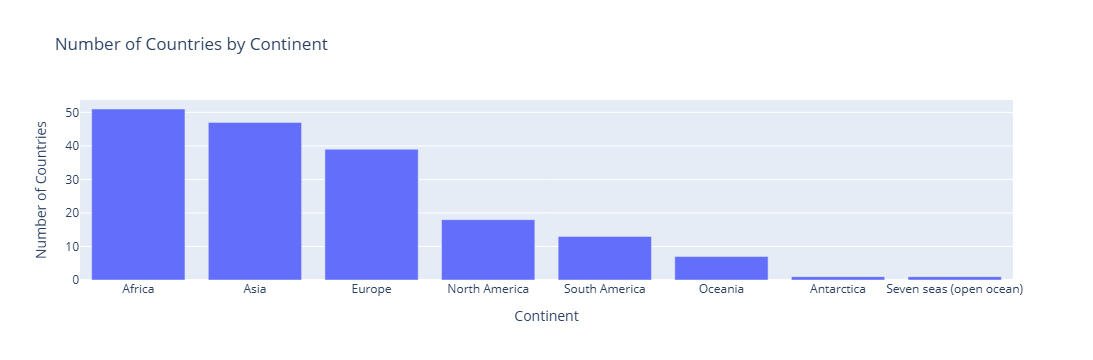

In [43]:
fig = px.bar(
    x=countries_by_continent.index,
    y=countries_by_continent.values,
    labels={"x": "Continent", "y": "Number of Countries"},
    title="Number of Countries by Continent",
)
fig

### Q2: Which region has the largest combined area in sq. km?

In [44]:
# Sum area by region
area_by_region = df.groupby("region_un")["area_km2"].sum().sort_values(ascending=False)
print(area_by_region)

top_region = area_by_region.index[0]
top_area = area_by_region.iloc[0]
print(f"\nAnswer: {top_region} with {top_area:,.2f} sq. km")

region_un
Americas                   4.224690e+07
Asia                       3.125246e+07
Africa                     2.994620e+07
Europe                     2.306522e+07
Antarctica                 1.233596e+07
Oceania                    8.504489e+06
Seven seas (open ocean)    1.160257e+04
Name: area_km2, dtype: float64

Answer: Americas with 42,246,901.54 sq. km


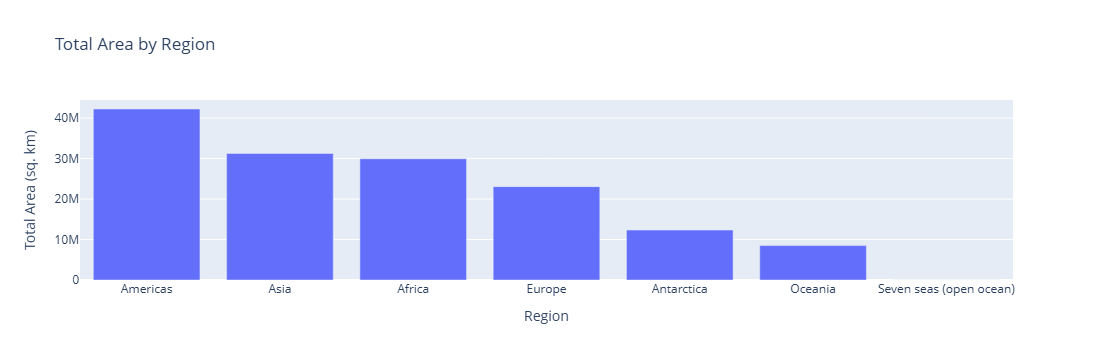

In [45]:
fig = px.bar(
    x=area_by_region.index,
    y=area_by_region.values,
    labels={"x": "Region", "y": "Total Area (sq. km)"},
    title="Total Area by Region",
)
fig

### Q3: Which country has the highest life expectancy?

In [46]:
# Find the country with the highest life expectancy (excluding NaN)
valid_life = df.dropna(subset=["lifeExp"])
top_life_idx = valid_life["lifeExp"].idxmax()
top_life_row = valid_life.loc[top_life_idx]

print(f"Answer: {top_life_row['name_long']} with life expectancy of {top_life_row['lifeExp']:.2f} years")

# Show top 10 for context
print("\nTop 10 countries by life expectancy:")
valid_life.nlargest(10, "lifeExp")[["name_long", "continent", "lifeExp"]]

Answer: Japan with life expectancy of 83.59 years

Top 10 countries by life expectancy:


,name_long,continent,lifeExp
155,Japan,Asia,83.587805
132,Spain,Europe,83.229268
127,Switzerland,Europe,83.197561
141,Italy,Europe,83.090244
144,Iceland,Europe,82.860976
137,Australia,Oceania,82.300000
110,Sweden,Europe,82.253659
128,Luxembourg,Europe,82.229268
76,Israel,Asia,82.153659
3,Canada,North America,81.953049


### Q4: Which subregion has the lowest / highest average GDP per capita?

In [47]:
# Average GDP per capita by subregion
avg_gdp = df.groupby("subregion")["gdpPercap"].mean().dropna().sort_values()

print("Average GDP per capita by subregion (ascending):")
print(avg_gdp.to_string())

print(f"\nLowest:  {avg_gdp.index[0]} (${avg_gdp.iloc[0]:,.2f})")
print(f"Highest: {avg_gdp.index[-1]} (${avg_gdp.iloc[-1]:,.2f})")

Average GDP per capita by subregion (ascending):
subregion
Eastern Africa                1796.434045
Western Africa                2221.161155
Melanesia                     4240.809443
Southern Asia                 6497.571240
Middle Africa                 8333.981095
Northern Africa               9079.476234
Southern Africa               9693.990137
Central America              10258.359233
Central Asia                 10911.961484
South America                13761.997210
South-Eastern Asia           17051.592972
Southern Europe              19510.242812
Caribbean                    19511.970865
Eastern Europe               19712.829171
Eastern Asia                 20481.537513
Western Asia                 31791.457802
Northern Europe              36058.752415
Australia and New Zealand    39001.264350
Northern America             47500.563580
Western Europe               56884.584962

Lowest:  Eastern Africa ($1,796.43)
Highest: Western Europe ($56,884.58)


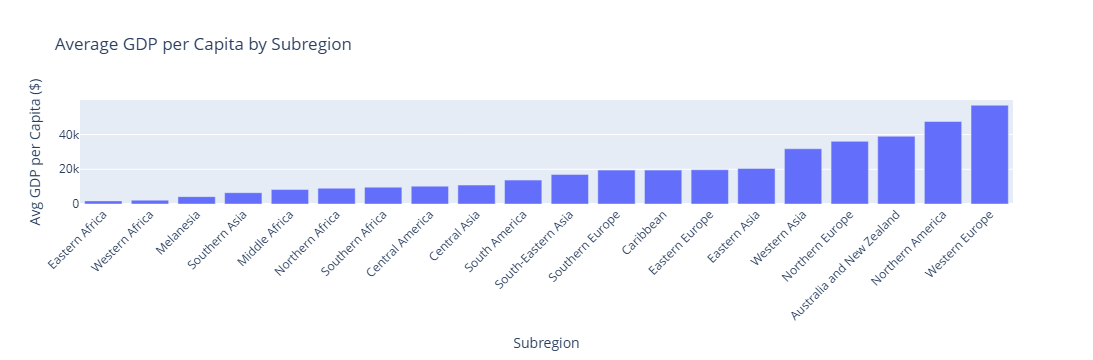

In [48]:
fig = px.bar(
    x=avg_gdp.index,
    y=avg_gdp.values,
    labels={"x": "Subregion", "y": "Avg GDP per Capita ($)"},
    title="Average GDP per Capita by Subregion",
)
fig.update_layout(xaxis_tickangle=-45)
fig

---

## Next Steps

Tasks 1-3 are complete in this notebook. The cleaned data has been exported to `cleaned_worldData.csv`.

**Task 4** (interactive filtering interface) and **Visualisations** are implemented in the Streamlit app. Run it with:

```bash
streamlit run app.py
```

See the `README.md` for full setup instructions.